# Import Libraries

In [4]:
import numpy as np
import pandas as pd
import sys
from scipy.sparse import csc_matrix,csr_matrix 
import pickle # Để lưu các kiểu dữ liệu thành file dưới máy
import seaborn as sns 

def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
df = pd.read_json('data.json',lines=True)

In [6]:
df.drop(columns=['article_link'],inplace=True)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


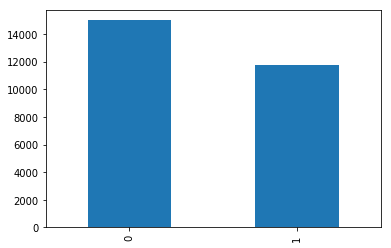

In [7]:
df['is_sarcastic'].value_counts().plot(kind='bar')

# Data processing

Trong data có nhiều kí tự lạ nên ta sẽ xử lí trước khi tokenize

In [10]:
from myNLPToolBox import TextPreprocessor as TP

TP.process(df,modes=['remove_unicode','remove_special','lowercase',
                           'remove_accents'])

df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret bl...,0
1,the roseanne revival catches up to our thorny ...,0
2,mom starting to fear sons web series closest t...,1
3,boehner just wants wife to listen not come up ...,1
4,jk rowling wishes snape happy birthday in the ...,0


# Create vocabulary count

In [7]:
def vocabcountDict(df):
    vocab = []
    for i in range(len(df)):
        vocab += df.loc[i,'headline'].split()
    vocabdict = {}
    lenvocab = len(set(vocab))
    for idx,term in enumerate(set(vocab)):
        if idx%1000==0:
            sys.stdout.write('\r'+'Progress..'+str(round(idx/lenvocab*100))+'%')
        freqidx = {'count':vocab.count(term),'idx':idx}
        vocabdict[term] = freqidx
    print('Done')
    return vocabdict
vocabdict = vocabcountDict(df)

Progress..0%

KeyboardInterrupt: 

In [196]:
save_obj(vocabdict,'vocabdict_stopwords') #Lưu lại vocab này (vocab có chứa stopwords)

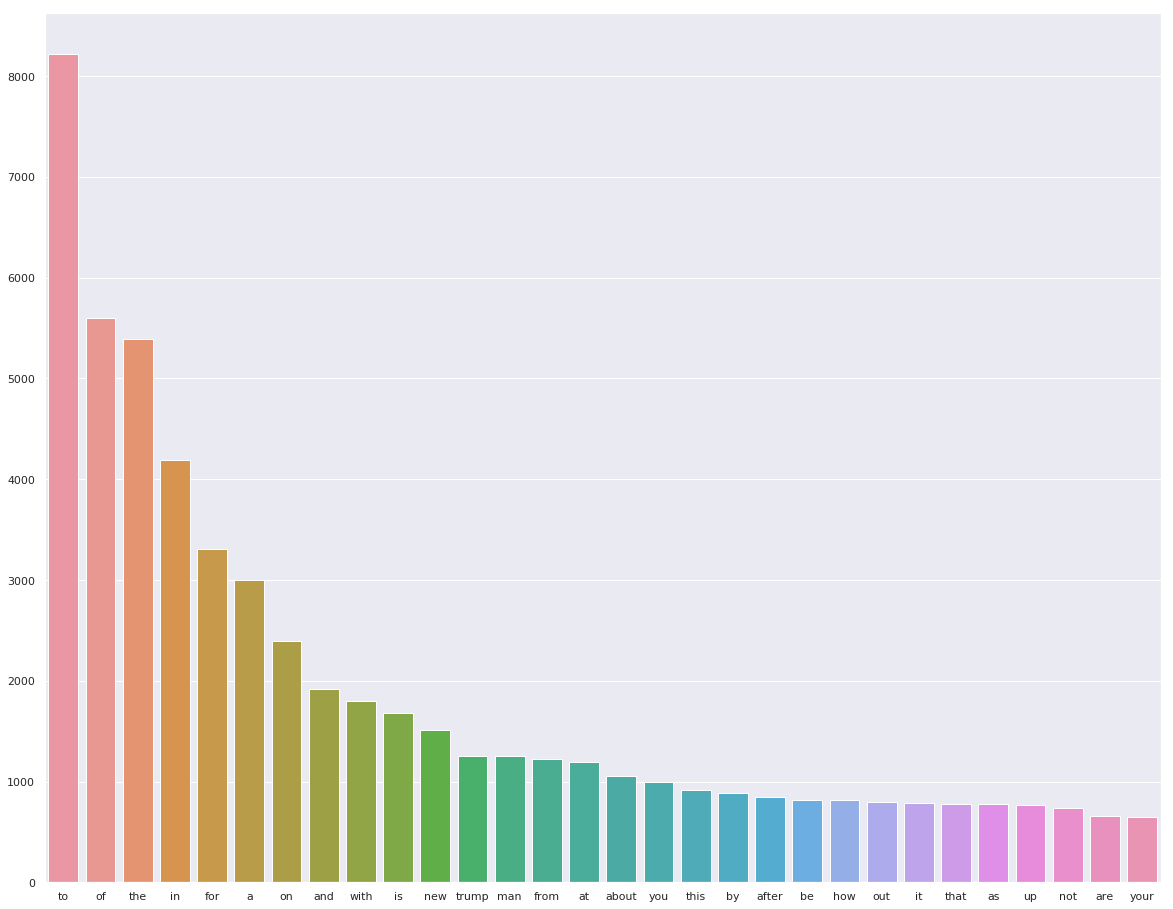

In [197]:
vocabdict = load_obj('vocabdict_stopwords')
def plotfreq(vocabdict):
    sorteddict = sorted(vocabdict.items(),key=lambda kv: kv[1]['count'],reverse=True)
    topwords = [a[0] for a in sorteddict[0:30]]
    topoccur = [a[1]['count'] for a in sorteddict[0:30]]
    sns.set(rc={'figure.figsize':(20,16)})
    ax = sns.barplot(x=topwords,y=topoccur)
plotfreq(vocabdict)

Có thể thấy những từ xuất hiện nhiều nhất là stopwords và cũng không mang nhiều ý nghĩa nên ta sẽ cân nhắc xóa bỏ chúng ra khỏi dataset. Lưu ý rằng bộ corpus của chúng ta rất ít (26k từ), nên chúng ta sẽ không xóa stopwords dựa trên số lần mà nó xuất hiện, vì có những từ là stopwords nhưng cũng không được sử dụng nhiều. Thay vào đó, chúng ta sẽ sử dụng bộ stopwords có sẵn trên mạng

# Remove stopwords

Đưa bộ stopwords lấy được từ trên mạng về

In [199]:
stopwords = open('stopwords.txt').read().split('\n')
print(stopwords[0:50])

["'ll", "'s", "'m", 'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has']


In [200]:
def remove_stopwords(str):
    return ' '.join([word for word in str.split() if word not in stopwords])
preprocessing(df,[remove_stopwords])
df.head()

,headline,is_sarcastic
0,former versace store clerk sues secret black c...,0
1,roseanne revival catches thorny political mood...,0
2,mom starting fear sons web series closest thin...,1
3,boehner just wants wife listen come alternativ...,1
4,jk rowling wishes snape happy birthday magical...,0


In [ ]:
# Split to train and test

In [10]:
train = df[:20000]
test = df[20000:]

# Save vocab dictionary

Vì quá trình tạo ra bộ dict đếm từ khá là lâu và tốn tài nguyên nên chúng ta sẽ lưu lại bộ từ điển này thành 1 file dưới máy để dùng lại sau này nếu cần

In [201]:
save_obj(vocabdict,'vocabdict') # Lưu bộ vocab không có stopwords

Chúng ta sẽ đếm lại bộ từ của chúng ta

In [202]:
vocabdict = vocabcountDict(df)

Progress..99%Done


In [9]:
plotfreq(vocabdict)


# Reload the vocab dictionary

In [7]:
vocabdict = load_obj('vocabdict_stopwords')
#vocabfreq = [(vocab,freq) for (vocab,freq) in zip(vocabfreq.keys(),vocabfreq.values())]

# Tạo ma trận trọng số dựa trên tf-idf encoding

In [15]:

# Trả về nếu term ở trong từ điển
def checkterm(vocabdict,term):
    return (term in vocabdict.keys())
# Embed Corpus về dạng ma trận
def logWord2Vec(corpus,vocabdict):
    WordVec = csc_matrix((corpus.shape[0],len(vocabdict)),dtype=np.float)
    lencorpus = len(corpus)
    maxtf = 0
    for idx,doc in enumerate(corpus):
        if idx%400==0:
            sys.stdout.write('\r'+'Embedding progress..'+str(round(idx/lencorpus*100))+'%')
        terms = doc.split()
        for term in terms:
            if not checkterm(vocabdict,term): continue
            num_term_doc = doc.count(term) # Number of term in doc
            maxtf = max(num_term_doc,0)
            num_term_corpus = vocabdict[term]['count'] # Number of occurence of the term in corpus
            tf = 1 + np.log(num_term_doc)
            idf = np.log(lencorpus/(1+num_term_corpus))
            tfidf = tf*idf
            termpos = vocabdict[term]['idx'] # Position of that term in matrix
            WordVec[idx,termpos] = tfidf
            # Remove that term out of the doc
            while term in terms:
                terms.remove(term)
    print('Số từ lặp lại tối đa trong 1 doc:', maxtf)
    print('Done!')
    return WordVec

        


In [23]:
# # Lưu ma trận embed không có stopwords
# vocabdict = load_obj('vocabdict_nostopwords')
# trainmat = logWord2Vec(train.iloc[:,0].values,vocabdict)
# testmat = logWord2Vec(test.iloc[:,0].values,vocabdict)
# save_obj(trainmat,'trainmat')
# save_obj(testmat,'testmat')
# Lưu ma trận embed với stopwords
vocabdict = load_obj('vocabdict_stopwords')
trainmat = logWord2Vec(train.iloc[:,0].values,vocabdict)
testmat = logWord2Vec(test.iloc[:,0].values,vocabdict)
save_obj(trainmat,'trainmat_stopwords')
save_obj(testmat,'testmat_stopwords')

Embedding progress..0%

/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:23: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.


Embedding progress..98%Số từ lặp lại tối đa trong 1 doc: 1
Done!
Embedding progress..95%Số từ lặp lại tối đa trong 1 doc: 1
Done!


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(trainmat,train.iloc[:,1])
ypred = model.predict(testmat)
accuracy_score(test.iloc[:,1].values,ypred)

/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7475033537039797

In [12]:
vocabdict = load_obj('vocabdict_nostopwords')
def checkterm(vocabdict,term):
    return (term in vocabdict.keys())
def augmentedWord2Vec(corpus,vocabdict):
    WordVec = csc_matrix((corpus.shape[0],len(vocabdict)),dtype=np.float)
    lencorpus = len(corpus)
    for idx,doc in enumerate(corpus):
        if idx%400==0:
            sys.stdout.write('\r'+'Embedding progress..'+str(round(idx/lencorpus*100))+'%')
        terms = doc.split()
        max_doc_tf = 0 
        for term in terms:
            num_term_doc = doc.count(term)
            max_doc_tf = max(num_term_doc,0) #Tìm tf của từ xuất hiên nhiều nhất
        for term in terms:
            if not checkterm(vocabdict,term): continue
            num_term_doc = doc.count(term)
            num_term_corpus = vocabdict[term]['count'] # Number of occurence of the term in corpus
            tf = 0.5 + 0.5*num_term_doc/max_doc_tf
            idf = max(0,np.log((lencorpus-num_term_corpus)/num_term_corpus))
            # Position of that term in matrix
            termpos = vocabdict[term]['idx']
            WordVec[idx,termpos] = tf*idf
            
            # Remove that term out of the doc
            while term in terms:
                terms.remove(term)
    print('Done!')
    return WordVec
trainmat = augmentedWord2Vec(train.iloc[:,0].values,vocabdict)

Embedding progress..0%

/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:23: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.


Embedding progress..98%Done!


In [13]:
testmat = augmentedWord2Vec(test.iloc[:,0].values,vocabdict)

Embedding progress..0%

/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:23: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.


Embedding progress..95%Done!


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(trainmat,train.iloc[:,1])
ypred = model.predict(testmat)
accuracy_score(test.iloc[:,1].values,ypred)

/home/truongphatuit/.conda/envs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7258905947235057

In [ ]:
hehe = csc_matrix((train.shape[0],len(vocabdict)),dtype=np.float)

In [3]:
ak = 3
locals()["ak"]

3